# Learning Discrete-Time Estimation and Control with Transformers

In [63]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

from kalman_filter import *
from helpers import *
from plotting import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 250 # how long to simulate the trajectory # 100

### Define the System Parameters

In [79]:
task_name = 'so2' # Choose from 'so2', 'motion', 'so3', 'accel', 'smd'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

In [80]:
num_traj = 20 # How many to test on
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

Trajectory shape (250, 2)
Measured shape (250, 2)


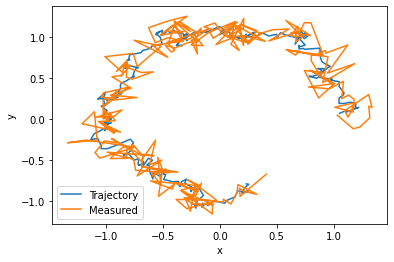

In [81]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

## 0. Optimization Based Approach using known A, B, C to get best possible fit

This is the baseline for BERT

In [66]:
err_opt = 0
ls_rec = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    print("Solving problem", i)
    ls_rec[i] = optimal_traj(A, B, C, Q, R, meas[i], x0, u_seq[i])

err_opt += np.linalg.norm(ls_rec - traj)**2 / T / num_traj
    
print("Average Squared Error", err_opt)

Solving problem 0
Solving problem 1
Solving problem 2
Solving problem 3
Solving problem 4
Solving problem 5
Solving problem 6
Solving problem 7
Solving problem 8
Solving problem 9
Solving problem 10
Solving problem 11
Solving problem 12
Solving problem 13
Solving problem 14
Solving problem 15
Solving problem 16
Solving problem 17
Solving problem 18
Solving problem 19
Average Squared Error 0.003106680006161456


## 1. Kalman Filtering using known A, B, C to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [97]:
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kfiltered[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr = np.linalg.norm(kfiltered - traj)**2 / num_traj / T
    
print("Average Squared Error:", err_fltr)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Average Squared Error: 0.00521991045973818


Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered shape (250, 2)


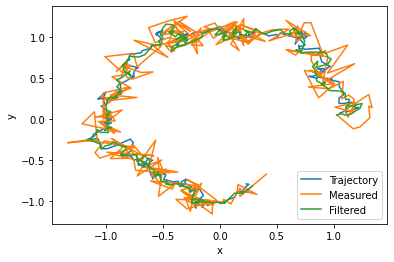

In [98]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered[0]})

### 1b. Kalman Filter with pure steady state gains

In [99]:
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    kfiltered_ss[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr_ss = np.linalg.norm(kfiltered_ss - traj)**2 / num_traj / T

print("Average Squared Error", err_fltr_ss)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Average Squared Error 0.005232128880409103


Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered shape (250, 2)


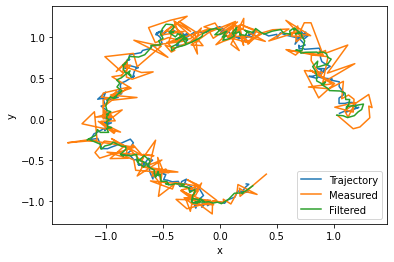

In [100]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered_ss[0]})

### 1c. Kalman Smoothing with Reverse Kalman Filter

In [101]:
err_kf_smoothed = 0

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0) # Forward KF
    fltr_fwd = kinematics_forward.simulate(meas[i], u_seq[i])
    
    kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=traj[i][-1]) # Backward KF
    fltr_bkwd = np.flip(kinematics_backward.simulate(np.flip(meas[i], axis=0), np.flip(u_seq[i], axis=0)), axis=0)
    
    # Kalman Smoothed (Avg forward and backward)
    smooth_states = (fltr_fwd + fltr_bkwd) / 2
    err_kf_smoothed += np.linalg.norm(smooth_states - traj[i])**2
    
print("Average Squared Error", err_kf_smoothed / num_traj / T)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

Note - The System Identification as implemented currently requires the state dimension to match the obs dimension. so2 and so3

In [72]:
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered[i] = id_fltr
    
err_id_fltr = np.linalg.norm(id_filtered[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

Average Squared Error 0.01755405334581026


Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered shape (250, 2)


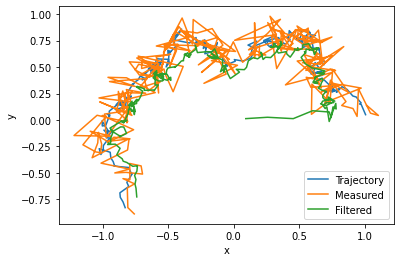

In [73]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': id_filtered[0]})

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [74]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i, :t], u_seq[i, :t])[-1]
    id_filtered_simulated[i] = id_fltr_sim
    
err_id_fltr_sim = np.linalg.norm(id_filtered_simulated[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr_sim)

Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 14 iterations
Converged in 14 iterations
Converged in 14 iterations
Converged in 15 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Trajectory: shape (250, 2)
ID + Filtered shape (250, 2)


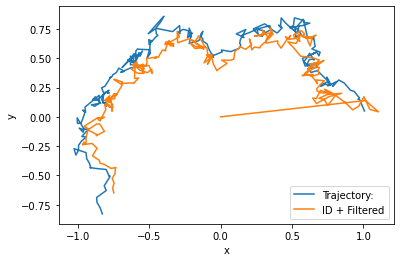

In [75]:
plot({"Trajectory:": traj[0], "ID + Filtered": id_filtered_simulated[0]})

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

Note that the learning the Kalman Filter can get roughly the same performance as the optimal Kalman Filter if trained for long enough. 

Iteration 1000 : Loss 3.893531928239961
Iteration 2000 : Loss 3.5920065430719315
Iteration 3000 : Loss 3.48712796391258
Iteration 4000 : Loss 3.436011949910578
Iteration 5000 : Loss 3.4076145943886584
Iteration 6000 : Loss 3.390467961223903
Iteration 7000 : Loss 3.37591623244741
Iteration 8000 : Loss 3.352472786830675
Iteration 9000 : Loss 3.3289357794864687
Iteration 10000 : Loss 3.3090895029553216
Iteration 11000 : Loss 3.2884188561646304
Iteration 12000 : Loss 3.2708139592507655
Iteration 13000 : Loss 3.2624969414233362
Iteration 14000 : Loss 3.2606669766520175


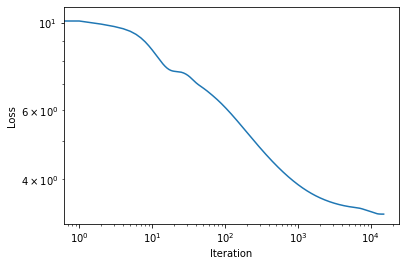

Average Squared Error 0.0058250194788422175


In [60]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = 0
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_learned_kf / T) #num_traj_test / T)

Trajectory shape (250, 2)
Measured shape (250, 2)
Optimal KF shape (250, 2)
Learned KF simulated shape (250, 2)


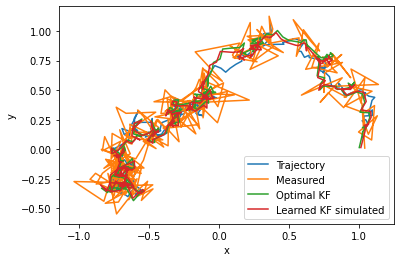

In [61]:
learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
learned_kfs_simulated[i] = learned_kf_sim
learned_kfs.append(kinematics)
plot({'Trajectory': traj[0], "Measured":meas[0], "Optimal KF": kfiltered[0], "Learned KF simulated": learned_kfs_simulated[0]})

In [ ]:
# The cell below is useful to compare the LearnedKF parameters to true parameters of the Kalman Filter
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

## ZOH Baseline 
Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [62]:
error = 0
for i in range(num_traj):
    for t in range(1,T):
        error += np.linalg.norm(meas[i, t] - meas[i, t-1])**2
print("Error is", error / num_traj / T)

Error is 0.04213346860074775


# Transformer-based techniques to learn the dynamics and filter the position

In [84]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 64 # use 64-dimensional embedding for now
batch_size = 32

### Test data

In [109]:
target_sequences_test = torch.from_numpy(meas)
input_sequences_test = torch.from_numpy(u_seq)
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [106]:
num_iterations = 2000

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=obs_dim,
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(device)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # Cast to PyTorch tensors
    target_sequences_train = torch.from_numpy(meas_batch) # trying to hit noisy data
    input_sequences_train = torch.from_numpy(u_batch)
    transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
    
    # Run through the GPT model
    decoder_output = gpt_model(transformer_input_train, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

    # Compute Loss and Backpropagate
    loss = loss_func(decoder_output, target_sequences_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    curr_loss = loss.item()
    losses.append(curr_loss)
    
    print('Iteration', i, ": Loss", curr_loss)

Iteration 0 : Loss 21936.60609908851
Iteration 1 : Loss 73351.29535110295
Iteration 2 : Loss 23380.343504903125
Iteration 3 : Loss 7577.053867972841
Iteration 4 : Loss 23328.908366899916
Iteration 5 : Loss 19359.051297762133
Iteration 6 : Loss 8487.147811902314
Iteration 7 : Loss 3251.9607148688283
Iteration 8 : Loss 4185.9911596562815
Iteration 9 : Loss 8360.304891289461
Iteration 10 : Loss 9332.607120696213
Iteration 11 : Loss 7387.935525620371
Iteration 12 : Loss 3255.2928942715953
Iteration 13 : Loss 2031.4838240334327
Iteration 14 : Loss 2536.34951675561
Iteration 15 : Loss 3257.303300935244
Iteration 16 : Loss 4300.168387606069
Iteration 17 : Loss 3550.1609345695083
Iteration 18 : Loss 2317.514261291782
Iteration 19 : Loss 1716.1370710122906
Iteration 20 : Loss 1503.2415650717949
Iteration 21 : Loss 1803.4752717789893
Iteration 22 : Loss 2111.688559637395
Iteration 23 : Loss 2268.7747856316646
Iteration 24 : Loss 2086.4615084343372
Iteration 25 : Loss 1362.8764052236795
Iteration

Iteration 212 : Loss 301.78978160108363
Iteration 213 : Loss 312.1891665730375
Iteration 214 : Loss 314.4740596310552
Iteration 215 : Loss 312.1278741000399
Iteration 216 : Loss 305.14804992836764
Iteration 217 : Loss 305.0551778759675
Iteration 218 : Loss 316.80751751141526
Iteration 219 : Loss 311.71621019209795
Iteration 220 : Loss 310.1197657746702
Iteration 221 : Loss 316.86461440391315
Iteration 222 : Loss 304.39103960639267
Iteration 223 : Loss 315.3046877523396
Iteration 224 : Loss 319.5280999017942
Iteration 225 : Loss 314.5150468163166
Iteration 226 : Loss 305.144378456056
Iteration 227 : Loss 311.34895062277553
Iteration 228 : Loss 310.06448793701077
Iteration 229 : Loss 310.58427336659213
Iteration 230 : Loss 309.481358172525
Iteration 231 : Loss 302.22574801473536
Iteration 232 : Loss 308.15946413388235
Iteration 233 : Loss 306.6136603102813
Iteration 234 : Loss 313.86827634151336
Iteration 235 : Loss 300.49474764448775
Iteration 236 : Loss 311.32888149246685
Iteration 237

Iteration 421 : Loss 292.9666429460008
Iteration 422 : Loss 282.84756149308225
Iteration 423 : Loss 285.88909446468244
Iteration 424 : Loss 285.4300489668401
Iteration 425 : Loss 280.0388575009692
Iteration 426 : Loss 283.89127077871615
Iteration 427 : Loss 305.66866252524653
Iteration 428 : Loss 287.85882697982436
Iteration 429 : Loss 285.55669397679674
Iteration 430 : Loss 288.31764336937283
Iteration 431 : Loss 284.83851313464277
Iteration 432 : Loss 285.77302270768735
Iteration 433 : Loss 288.9173812000599
Iteration 434 : Loss 288.5930955979699
Iteration 435 : Loss 280.13877728640955
Iteration 436 : Loss 282.6830566133158
Iteration 437 : Loss 282.0597043627152
Iteration 438 : Loss 283.6769798603233
Iteration 439 : Loss 283.1924021369159
Iteration 440 : Loss 282.6612579915148
Iteration 441 : Loss 290.6388786448913
Iteration 442 : Loss 288.61825069557744
Iteration 443 : Loss 285.3573849097281
Iteration 444 : Loss 293.7990801115367
Iteration 445 : Loss 292.63850771634964
Iteration 446

Iteration 630 : Loss 270.2272881711913
Iteration 631 : Loss 276.06617178856675
Iteration 632 : Loss 284.0347561744394
Iteration 633 : Loss 283.06548314487776
Iteration 634 : Loss 266.0179216177416
Iteration 635 : Loss 268.7255391030941
Iteration 636 : Loss 277.86222035769094
Iteration 637 : Loss 276.0099981902694
Iteration 638 : Loss 272.90569286109087
Iteration 639 : Loss 268.14897166705487
Iteration 640 : Loss 274.70635479285454
Iteration 641 : Loss 274.38153459639165
Iteration 642 : Loss 263.58522738056894
Iteration 643 : Loss 271.9132352709228
Iteration 644 : Loss 269.36230572456435
Iteration 645 : Loss 268.3263068092698
Iteration 646 : Loss 268.9394507763879
Iteration 647 : Loss 263.93059566835814
Iteration 648 : Loss 266.4495492055485


KeyboardInterrupt: 

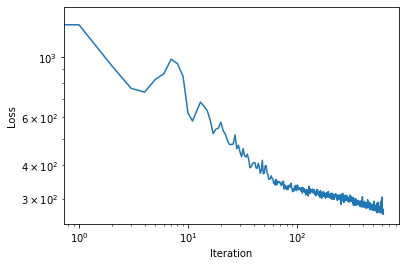

In [108]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale('log')
plt.show()

### Test the GPT-style Model

Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered by GPT shape (250, 2)
Optimal KF shape (250, 2)


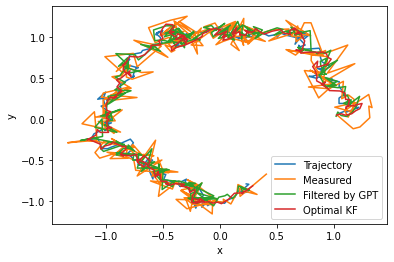

Average Squared Error between traj and meas 0.020053554613360454
Average Squared Error of filtered vs traj 0.013710870645885337
Average Squared Error between filtered and meas 0.03420985705947072


In [112]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
i = 0 # index to visualize (0 through 19)

filtered = gpt_transformer_sim.detach().numpy()

plot({"Trajectory": traj[i], "Measured": meas[i], "Filtered by GPT": filtered[i], "Optimal KF": kfiltered[i]})

print('Average Squared Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of filtered vs traj', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)

## BERT-style: Transformer Encoder only, predict true trajectory from Noisy Measurements

In [126]:
num_iterations = 500

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, # trying to hit the actual state (not the observation)
                n_layers=6, n_heads=4, d_filter=256, dropout=None)

optimizer = torch.optim.Adam(bert_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # Cast to PyTorch tensors
    meas_sequences_train = torch.from_numpy(meas_batch)
    input_sequences_train = torch.from_numpy(u_batch)
    transformer_input_train = torch.cat((meas_sequences_train, input_sequences_train), dim=2) # shape [batch_size, seq_len, (obs_dim+input_dim)]
    true_positions_train = torch.from_numpy(traj_batch)

    # Run through the model
    encoder_output = bert_model(transformer_input_train, encoder_mask=None)    
    
    # Loss 
    loss = loss_func(encoder_output, true_positions_train) # Trying to hit true positions
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    curr_loss = loss.item()
    losses.append(curr_loss)
        
    print('Iteration', i, ": Loss", curr_loss)

Iteration 0 : Loss 41398.40771030919
Iteration 1 : Loss 46384.4421321741
Iteration 2 : Loss 18519.67428330528
Iteration 3 : Loss 6307.738797117925
Iteration 4 : Loss 5774.575236112944
Iteration 5 : Loss 11383.746135139067
Iteration 6 : Loss 9964.781682081204
Iteration 7 : Loss 4354.214744661648
Iteration 8 : Loss 1968.446400402659
Iteration 9 : Loss 3487.929069448086
Iteration 10 : Loss 5009.615024440673
Iteration 11 : Loss 4950.1573573797705
Iteration 12 : Loss 3201.839793511349
Iteration 13 : Loss 1813.7945911458323
Iteration 14 : Loss 903.3272289447327
Iteration 15 : Loss 1595.6791975544982
Iteration 16 : Loss 2740.9904355056897
Iteration 17 : Loss 2952.135018425891
Iteration 18 : Loss 2167.9002928228206
Iteration 19 : Loss 1429.9061902285948
Iteration 20 : Loss 975.5344934087303
Iteration 21 : Loss 861.7443886599127
Iteration 22 : Loss 1219.965187745005
Iteration 23 : Loss 1165.711327894116
Iteration 24 : Loss 1325.9055892713468
Iteration 25 : Loss 1102.8460292357693
Iteration 26 :

Iteration 210 : Loss 137.8158137274933
Iteration 211 : Loss 135.90403242332894
Iteration 212 : Loss 138.78203448818292
Iteration 213 : Loss 135.5592266290254
Iteration 214 : Loss 140.90593105829083
Iteration 215 : Loss 131.89690575703486
Iteration 216 : Loss 138.4101083525385
Iteration 217 : Loss 139.33908297375433
Iteration 218 : Loss 143.27332744973697
Iteration 219 : Loss 133.71685335380704
Iteration 220 : Loss 138.4158190913905
Iteration 221 : Loss 134.0528795984094
Iteration 222 : Loss 139.17781387025903
Iteration 223 : Loss 136.77502448485103
Iteration 224 : Loss 136.44098420129154
Iteration 225 : Loss 134.23438320664667
Iteration 226 : Loss 134.3689069424634
Iteration 227 : Loss 130.45586924723767
Iteration 228 : Loss 134.75185270521268
Iteration 229 : Loss 132.82589896962548
Iteration 230 : Loss 140.1740023464569
Iteration 231 : Loss 134.05737546143035
Iteration 232 : Loss 133.52938435263263
Iteration 233 : Loss 135.9521218663338
Iteration 234 : Loss 134.95093685652796
Iteratio

Iteration 417 : Loss 119.88463824488909
Iteration 418 : Loss 123.59923445094549
Iteration 419 : Loss 119.63999512888218
Iteration 420 : Loss 125.93196021266735
Iteration 421 : Loss 123.47730613323264
Iteration 422 : Loss 121.40392123655403
Iteration 423 : Loss 118.90130983329195
Iteration 424 : Loss 120.85940595367914
Iteration 425 : Loss 119.11961875691246
Iteration 426 : Loss 120.06345111064925
Iteration 427 : Loss 119.6972494281843
Iteration 428 : Loss 120.02407203740222
Iteration 429 : Loss 121.4137495944196
Iteration 430 : Loss 116.69854321085938
Iteration 431 : Loss 120.37631454420497
Iteration 432 : Loss 116.5850330029945
Iteration 433 : Loss 125.03491732164613
Iteration 434 : Loss 121.23892538760695
Iteration 435 : Loss 123.70679097642807
Iteration 436 : Loss 115.33528226808579
Iteration 437 : Loss 124.818448442972
Iteration 438 : Loss 117.5112757050154
Iteration 439 : Loss 117.58816140886604
Iteration 440 : Loss 115.08720178052562
Iteration 441 : Loss 119.56540701691934
Iterat

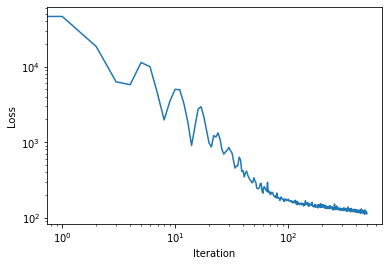

In [130]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")

plt.show()

Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered shape (250, 2)
Optimal KF shape (250, 2)


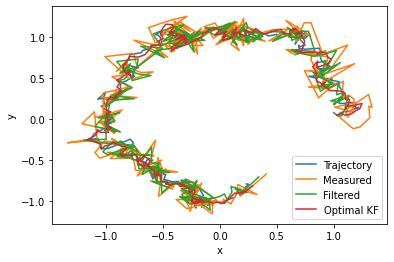

Error between traj and meas 0.020053554613360454
Average Squared Error of BERT 0.016155532281065744
Error between filtered and meas 0.007757277461856676


In [132]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
i = 0

filtered = bert_transformer_sim.detach().numpy()

plot({"Trajectory": traj[i], "Measured":meas[i], "Filtered":filtered[i], "Optimal KF":kfiltered[i]})

print('Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)